An analysis of the label consistency between the NIH Chest Xray 14 data, and two published relabelings of it.  The Kaggle/RSNA Pneumonia detection challenge, and the relabeled subset described in Majkowska et al.

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import glob
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pathlib
import zipfile
from io import BytesIO
from PIL import Image
import pydicom
import tqdm
import pickle
from utils import *

In [3]:
%aimport torchxrayvision
%aimport torchxrayvision.datasets
import torchxrayvision as xrv

In [4]:
nih_imgpath='/tmp/datapath/chest_xray/images'
kaggle_imgpath='/tmp/stage_2_train_images'

In [5]:
NIH=xrv.datasets.NIH_Dataset(
               imgpath=nih_imgpath, 
               views=["PA","AP"],
               unique_patients=False,
               normalize=False
)

In [6]:
NIH_metadata=dict()
print("Organize cxr14 metadata")
sys.stdout.flush()
for i,row in tqdm.tqdm(NIH.csv.iterrows()):
    NIH_metadata[row["Image Index"]]=row.to_dict()
    NIH_metadata[row["Image Index"]]['Index']=i


Organize cxr14 metadata


112120it [00:19, 5859.48it/s]


In [7]:
# rsna matches is computed externally, and is a dictionary of the rsna metadata
# and the best match to an NIH image, including mean squared error of that match
#
# the first match used 
rsnamatches=pickle.load(open('rsnamatches.pkl','rb'))


In [8]:
Kaggle=xrv.datasets.Kaggle_Dataset(
    kaggle_imgpath,
    views=["PA","AP"],
    unique_patients=False,
    normalize=False,
    extension=".dcm")

In [9]:
Z=Kaggle[2]
print(Kaggle.pathologies)
print(Z['img'].shape)
print(Z['lab'])
print(Z['idx'])

['Lung Opacity', 'Pneumonia']
(1, 1024, 1024)
[0. 0.]
2


In [10]:
Kaggle_metadata=dict()
print("Organize kaggle metadata")
sys.stdout.flush()
for i,row in tqdm.tqdm(Kaggle.csv.iterrows()):
    k=row["patientId"]
    #if k in Kaggle_metadata:
    #    print(k,Kaggle_metadata[k])
    #    print(k,row.to_dict())
    Kaggle_metadata[row["patientId"]]=row.to_dict()
    Kaggle_metadata[row["patientId"]]['Index']=i


Organize kaggle metadata


30227it [00:05, 5199.57it/s]


In [11]:
np.unique(Kaggle.csv["Target"].values)

array([0, 1])

In [12]:
# examine the worst matches in terms of MSE
# speculate that mse of 3 better is almost certainly a true match
for i,(k,v) in enumerate(sorted(rsnamatches.items(),key=lambda x:-x[1]['mse'])):
    if v['mse']<3:
        break
    print(i,k,v)
# based on visual inspection (see below), recommend to consider any image with mse > 10 as having no match.


0 3802b256-c042-4f52-ab00-73877c1d1a57 {'info': ['Normal'], 'mse': 102.77637672424316, 'cxr_match': '00022864_000.png'}
1 35621d68-0915-463c-b0f8-2365c6e56e11 {'info': ['Normal'], 'mse': 100.71100902557373, 'cxr_match': '00006015_003.png'}
2 ee373825-44f6-45ca-8ec9-d2d1d9541450 {'info': ['Lung Opacity'], 'mse': 99.51716995239258, 'cxr_match': '00016050_000.png'}
3 989f9f7f-3a72-4aae-afdc-9f3878518598 {'info': ['Normal'], 'mse': 98.99509906768799, 'cxr_match': '00008008_036.png'}
4 e5f292ae-f1e5-497c-b0a0-68f1aa2196b2 {'info': ['No Lung Opacity / Not Normal'], 'mse': 98.83741664886475, 'cxr_match': '00022528_014.png'}
5 6b6e92df-63fb-407d-9b69-e2de8ff1dcb8 {'info': ['Normal'], 'mse': 98.77909660339355, 'cxr_match': '00015386_010.png'}
6 ae59f8e3-455f-4f96-b686-465a38a0f3e2 {'info': ['Lung Opacity', 'Lung Opacity'], 'mse': 98.59914588928223, 'cxr_match': '00016719_003.png'}
7 8ec04c93-93ed-480f-83aa-8d89c1063505 {'info': ['No Lung Opacity / Not Normal'], 'mse': 98.42719459533691, 'cxr_ma

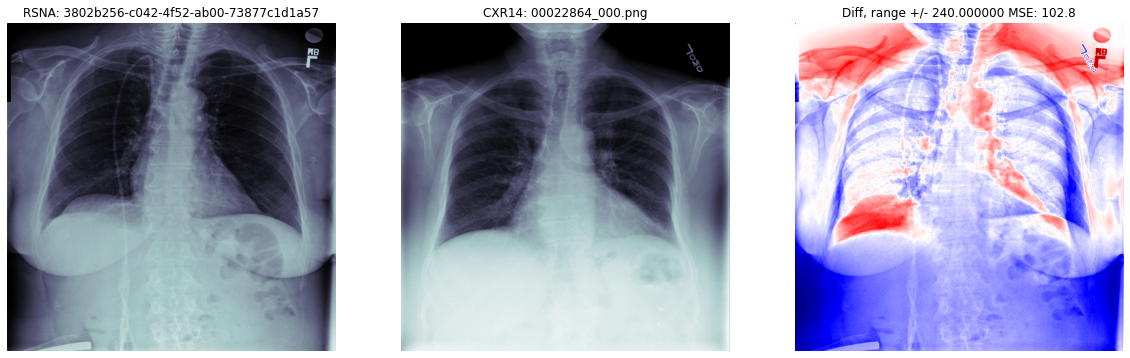

In [13]:
# Visual inspection of the match to the CXR14 data
def inspect_match(k,matches=rsnamatches):
    v=matches[k]
    rsna_img=Kaggle[Kaggle_metadata[k]['Index']]['img'].squeeze()
    #with zipfile.ZipFile(rsna_zip) as zf:
    #    f="stage_2_train_images/%s.dcm"%k
    #    fd=pydicom.filereader.dcmread(BytesIO(zf.read(f)))
    #    rsna_img=fd.pixel_array
    cxr14_img=NIH[ NIH_metadata[v['cxr_match']]['Index'] ]['img'].squeeze()
    fig=plt.figure(figsize=(20,7))
    plt.subplot(1,3,1)
    plt.imshow(rsna_img,cmap='bone')
    plt.axis('off')
    plt.title("RSNA: %s"%k)
    plt.subplot(1,3,2)
    plt.imshow(cxr14_img,cmap='bone')
    plt.axis('off')
    plt.title("CXR14: %s"%v['cxr_match'])
    plt.subplot(1,3,3)
    delta_img=rsna_img.astype('float32')-cxr14_img.astype('float32')
    rng=max(abs(delta_img.max()),abs(delta_img.min()))
    plt.imshow(delta_img,cmap='seismic',vmin=-rng, vmax=rng)
    plt.axis('off')
    plt.title("Diff, range +/- %f MSE: %.1f"%(rng,v['mse']))
    plt.show()
    plt.close(fig)


inspect_match('3802b256-c042-4f52-ab00-73877c1d1a57')

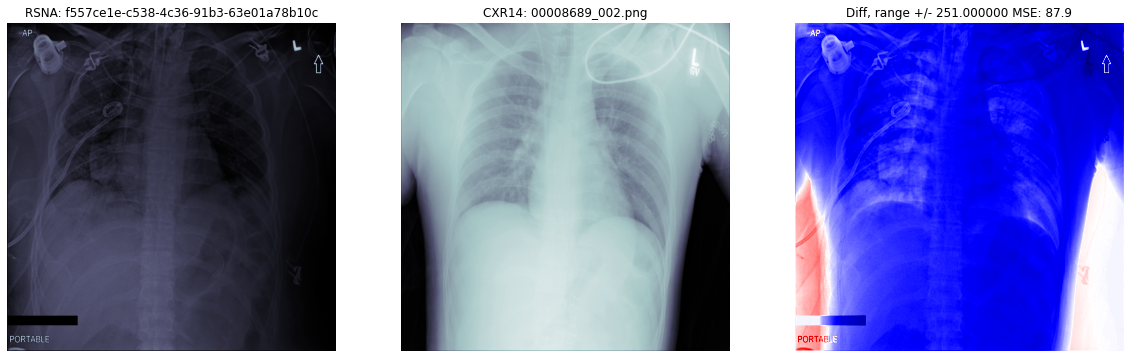

In [14]:
inspect_match('f557ce1e-c538-4c36-91b3-63e01a78b10c')

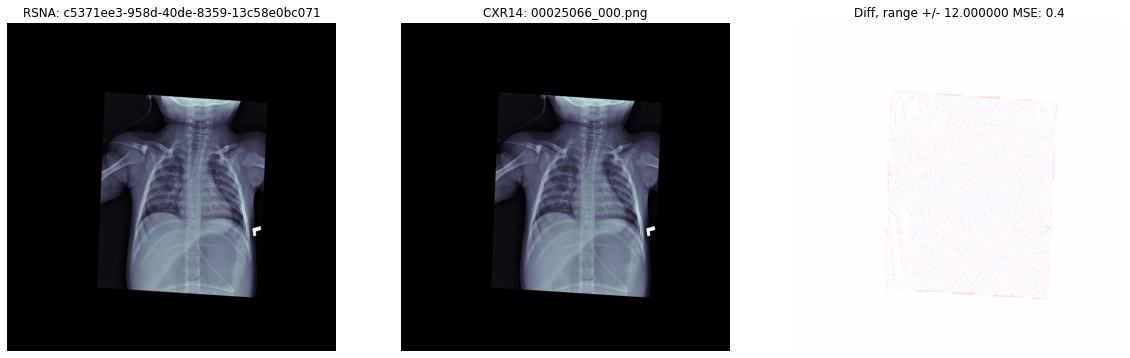

In [15]:
inspect_match('c5371ee3-958d-40de-8359-13c58e0bc071')

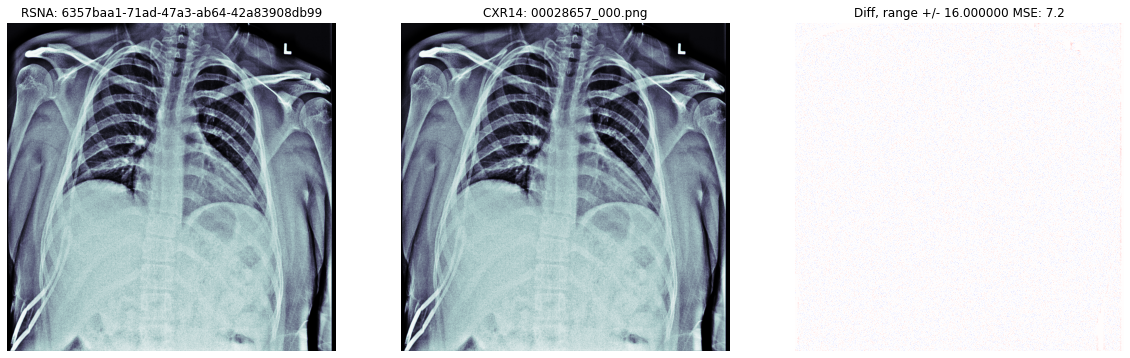

In [16]:
inspect_match('6357baa1-71ad-47a3-ab64-42a83908db99')

In [17]:
# load the google data, and make it into dictionaries
val_relabel=pd.read_csv('/tmp/datapath/chest_xray_relabel/validation_labels.csv')
test_relabel=pd.read_csv('/tmp/datapath/chest_xray_relabel/test_labels.csv')
val_lbl=dict()
for _,row in val_relabel.iterrows():
    val_lbl[row["Image Index"]]=row.to_dict()
test_lbl=dict()
for _,row in test_relabel.iterrows():
    test_lbl[row["Image Index"]]=row.to_dict()

In [18]:
Google=xrv.datasets.NIH_Google_Dataset(
               imgpath=nih_imgpath, 
               views=["PA","AP"],
               unique_patients=False,
               normalize=False
)

In [19]:
Google_metadata=dict()
print("Organize google metadata")
sys.stdout.flush()
for i,row in tqdm.tqdm(Google.csv.iterrows()):
    k=row["Image Index"]
    #if k in Kaggle_metadata:
    #    print(k,Kaggle_metadata[k])
    #    print(k,row.to_dict())
    Google_metadata[k]=row.to_dict()
    Google_metadata[k]['Index']=i

Organize google metadata


4376it [00:00, 6367.50it/s]


In [20]:
Google.csv.head()#len(Google.csv),len(val_lbl)+len(test_lbl)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Fracture,Pneumothorax,Airspace opacity,Nodule or mass,Set Id
0,00000013_008.png,No Finding,8,13,60,M,AP,3056,2544,0.139,0.139,NO,NO,YES,NO,test
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,57,M,AP,2500,2048,0.168,0.168,NO,YES,NO,NO,test
2,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,NO,NO,YES,NO,test
3,00000032_009.png,No Finding,9,32,55,F,AP,2500,2048,0.168,0.168,NO,NO,YES,NO,test
4,00000032_011.png,Infiltration,11,32,55,F,AP,2500,2048,0.168,0.168,NO,NO,YES,NO,test


In [21]:
# Verify what fraction of the google data is also in the rsna data
found=0
for k,v in rsnamatches.items():
    if v['mse']<10:  # skip false matches
        if v['cxr_match'] in Google_metadata:
            found+=1
print("%d images are in both Google and Kaggle.  This is %.1f%% of Google and %.1f%% of Kaggle"%(found,
                                                                                                  float(found)*100/len(Google_metadata),
                                                                                                  float(found)*100/len(Kaggle_metadata)
                                                                                                 ))


1136 images are in both Google and Kaggle.  This is 26.0% of Google and 4.3% of Kaggle


In [22]:
# both the Google data table and the original NIH data table have a column, Finding Label
# Find images where the Finding labels within the Google metadata do not agree with the NIH
finding_mismatches=dict()
for k,v in Google_metadata.items():
    if v['Finding Labels']!=NIH_metadata[k]['Finding Labels']:
        finding_mismatches[k]=(v['Finding Labels'],NIH_metadata[k]['Finding Labels'])
        #print("Mismatch with NIH:",k,v['Finding Labels'],NIH_metadata[k]['Finding Labels'])
print("There are %d cases where the Google finding label does not match the NIH finding label"%(len(finding_mismatches)))
# Find images where the Finding labels within the Google metadata are inconsistent with the Google image classification
count_mismatches=0
count_both_mismatches=0
for k,v in Google_metadata.items():
    mismatch=False
    if (('Pneumothorax' in v['Finding Labels'] and v['Pneumothorax']=='NO')
        or ('Pneumothorax' not in v['Finding Labels'] and v['Pneumothorax']=='YES')):
        mismatch=True
    mass_or_nodule= ('Mass' in v['Finding Labels']) or ('Nodule' in v['Finding Labels'])
    if ((mass_or_nodule and v['Nodule or mass']=='NO')
        or(not mass_or_nodule and v['Nodule or mass']=='YES')):
        mismatch=True
    if mismatch:
        count_mismatches+=1
        if k in finding_mismatches:
            count_both_mismatches+=1
        #print("Self mismatch",k,v)
print("There are %d cases where the Google data does not match its own finding label."%(count_mismatches,),
      " %d of those are mismatched with NIH"%(count_both_mismatches))

There are 16 cases where the Google finding label does not match the NIH finding label
There are 772 cases where the Google data does not match its own finding label.  5 of those are mismatched with NIH


In [23]:
# there are multiple codes present for the rsna data (multiple highlighted regions)
# verify that the codes are consistent.
#
# No lung opacity / not normal is an abnormality that does not provide evidence of pneumonia
codes=set()
for k,v in rsnamatches.items():
    infostring="|".join(sorted(list(set(v['info']))))
    codes.add(infostring)
for code in sorted(list(codes)):
    print(code)


Lung Opacity
No Lung Opacity / Not Normal
Normal


Cross check, nih pneumonia + 756
Cross check, google opacity + 707


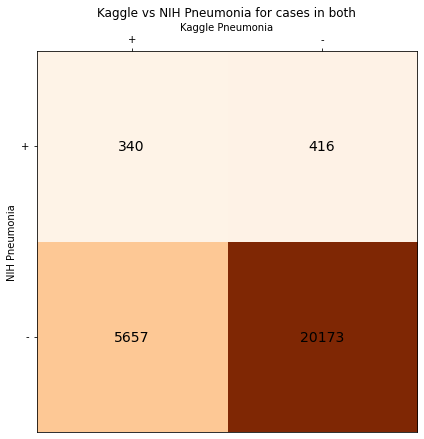

26586.0
Accuracy: 77.2%
F1      : 0.101


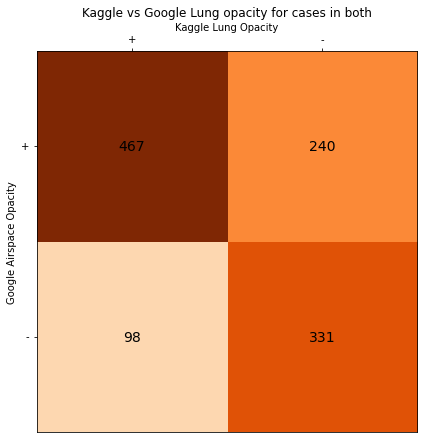

Accuracy: 70.2%
F1      : 0.734


In [24]:
# Compute confusion matrix between RSNA data and CXR (on pneumonia), and RSNA data and google data (for lung opacity)
pneumonia_cm_nih_kaggle=np.zeros((2,2))
opacity_cm_google_kaggle=np.zeros((2,2))
check_nih_pos_pneumonia=0
check_google_pos_opacity=0
for k,v in rsnamatches.items():
    if v['mse']<10:
        infostring="|".join(sorted(list(set(v['info']))))
        if infostring == 'Lung Opacity':
            opacity=1
            pneumonia=1
        elif 'Not Normal' in infostring:
            pneumonia=0
        elif 'Normal' == infostring:
            pneumonia=0
            opacity=0
        else:
            assert(False and "This should be all the valid cases")
        pnm_nih=1 if 'Pneumonia' in NIH_metadata[v['cxr_match']]['Finding Labels'] else 0
        check_nih_pos_pneumonia+=pnm_nih
        pneumonia_cm_nih_kaggle[pnm_nih,pneumonia]+=1

        opacity_ggl=None
        if v['cxr_match'] in Google_metadata:
            opacity_ggl=1 if 'Y' in Google_metadata[v['cxr_match']]['Airspace opacity'] else 0
            check_google_pos_opacity+=opacity_ggl
        if opacity_ggl is not None:
            opacity_cm_google_kaggle[opacity_ggl,opacity]+=1
print("Cross check, nih pneumonia +",check_nih_pos_pneumonia)
print("Cross check, google opacity +",check_google_pos_opacity)
#cm, row_labels, col_labels, xlabel='Column Categories',ylabel='Row Categories',title=""
draw_confusion_matrix(pneumonia_cm_nih_kaggle,["-","+"],["-","+"],"Kaggle Pneumonia","NIH Pneumonia","Kaggle vs NIH Pneumonia for cases in both",figsize=(7,7))
print(np.sum(pneumonia_cm_nih_kaggle))
print("Accuracy: %.1f%%"%(100.*(pneumonia_cm_nih_kaggle[0,0]+pneumonia_cm_nih_kaggle[1,1])/np.sum(pneumonia_cm_nih_kaggle)))
print("F1      : %.3f"%(2.*pneumonia_cm_nih_kaggle[1,1]/(2.*pneumonia_cm_nih_kaggle[1,1] + pneumonia_cm_nih_kaggle[1,0]+pneumonia_cm_nih_kaggle[0,1])))
draw_confusion_matrix(opacity_cm_google_kaggle,["-","+"],["-","+"],"Kaggle Lung Opacity","Google Airspace Opacity","Kaggle vs Google Lung opacity for cases in both",figsize=(7,7))
print("Accuracy: %.1f%%"%(100.*(opacity_cm_google_kaggle[0,0]+opacity_cm_google_kaggle[1,1])/np.sum(opacity_cm_google_kaggle)))
print("F1      : %.3f"%(2.*opacity_cm_google_kaggle[1,1]/(2.*opacity_cm_google_kaggle[1,1] + opacity_cm_google_kaggle[1,0]+opacity_cm_google_kaggle[0,1])))

        
            
            



Cross check NIH positive ptx 236
Cross check NIH positive nodule or mass 450


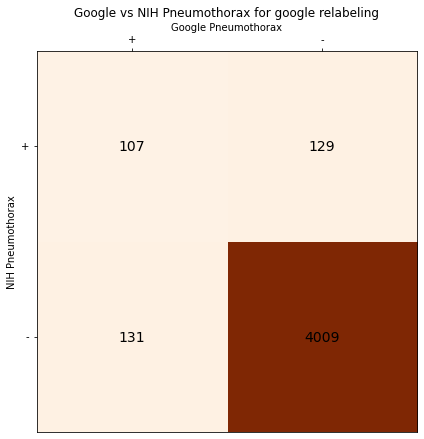

Accuracy: 94.1%
F1      : 0.451


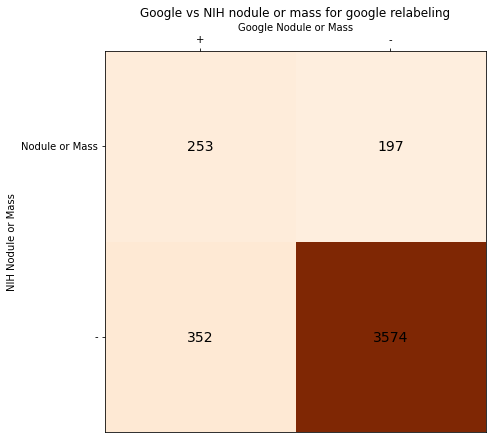

Accuracy: 87.5%
F1      : 0.480


In [27]:
ptx_cm=np.zeros((2,2))
nm_cm=np.zeros((2,2))
nih_ptx_pos_check=0
nih_nm_pos_check=0
for k,v in sorted(Google_metadata.items()):
    nm_nih=0
    if 'Nodule' in NIH_metadata[k]['Finding Labels'] or 'Mass' in NIH_metadata[k]['Finding Labels']:
        nm_nih=1
    if nm_nih>0:
        nih_nm_pos_check+=1
    ptx_nih=1 if 'Pneumothorax' in NIH_metadata[k]['Finding Labels'] else 0
    nih_ptx_pos_check+=ptx_nih
    ptx_ggl=1 if 'Y' in v['Pneumothorax'] else 0
    nm_ggl=1 if 'Y' in v['Nodule or mass'] else 0
    ptx_cm[ptx_nih,ptx_ggl]+=1
    nm_cm[nm_nih,nm_ggl]+=1
#These cross checks are so I can sum up the relevant column or row in the table and check I am adding up correctly.
print("Cross check NIH positive ptx",nih_ptx_pos_check)
print("Cross check NIH positive nodule or mass",nih_nm_pos_check)
draw_confusion_matrix(ptx_cm,["-","+"],["-","+"],"Google Pneumothorax","NIH Pneumothorax","Google vs NIH Pneumothorax for google relabeling",figsize=(7,7))
print("Accuracy: %.1f%%"%(100.*(ptx_cm[0,0]+ptx_cm[1,1])/np.sum(ptx_cm)))
print("F1      : %.3f"%(2.*ptx_cm[1,1]/(2.*ptx_cm[1,1] + ptx_cm[1,0]+ptx_cm[0,1])))
draw_confusion_matrix(nm_cm,["-","Nodule or Mass"],["-","+"],"Google Nodule or Mass","NIH Nodule or Mass","Google vs NIH nodule or mass for google relabeling",figsize=(7,7))

print("Accuracy: %.1f%%"%(100.*(nm_cm[0,0]+nm_cm[1,1])/np.sum(nm_cm)))
print("F1      : %.3f"%(2.*nm_cm[1,1]/(2.*nm_cm[1,1] + nm_cm[1,0]+nm_cm[0,1])))
